# Aprendizado de Máquina com Spark

Spark oferece um ambiente completo para aprendizado de máquina em sua biblioteca `MLlib`, que implementa diversas tarefas de modo distribuído e escalável. Neste notebook veremos alguns exemplos de suas funcionalidades, que podem ser divididas em três grandes categorias:
- Transformações de Características
- Algoritmos
- Otimização 

Vamos começar importando as bibliotecas do Spark e inicializando uma `SparkSession`.

In [1]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

print(spark)

2021-12-18 09:29:07,215 WARN util.Utils: Your hostname, bigdatavm-VirtualBox resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
2021-12-18 09:29:07,256 WARN util.Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2021-12-18 09:29:08,355 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Transformações de Características

Spark oferece uma grande quantidade de transformações de características que podem ser aplicadas em Dataframes. Essas transformações vão além das funcionalidades vistas antes na biblioteca SQL. 


As transformações de características estão localizadas no módulo `pyspark.ml.feature`. Podemos checar todas as funcionalidades na [documentação](https://spark.apache.org/docs/latest/ml-features.html). No caso deste notebook, veremos as cinco mais comuns:
- Indexador de String
- Transformador de representações OneHot
- Transformador de valores em _buckets_
- TF-IDF
- Criador de vetores


Mas antes de vermos eles, vamos importar e preparar as bases de dados `flights.csv` e `sms.csv`, usando SQL.

Preparando `flights.csv`:

In [7]:
import pyspark.sql.functions as F

# importando e olhando o Schema
flights_df = spark.read.csv('file:///home/bigdata-vm/Desktop/BigDataAulasPUC/Datasets/Flights_new/flights.csv',
                           header = True, inferSchema=True, nullValue='NA')
flights_df.printSchema()

# definindo a coluna alvo
flights_df = flights_df.withColumn('Y_num', flights_df.arr_delay)
flights_df = flights_df.withColumn('Y_bin', F.when(flights_df['arr_delay'] > 5, 1).otherwise(0))

# normalizando valores por min-max
columns_to_scale = ['dep_delay', 'distance']

def min_max_norm(df, cols):
    for col in cols:
        max_value = df.agg({col:'max'}).collect()[0][0]
        min_value = df.agg({col:'min'}).collect()[0][0]
        new_column = col+'_scaled'
        df = df.withColumn(new_column, (df[col] - min_value) / (max_value - min_value))
    return df

flights_df = min_max_norm(flights_df, columns_to_scale)

# remover colunas desnecessarias
flights_df = flights_df.drop(*['year','month','day','dep_time','dep_delay', 'arr_time',
                              'arr_delay','tailnum', 'flight', 'air_time', 'minute'])

#remover linhas com valores nulos
print(flights_df.count())
flights_df = flights_df.dropna()
print(flights_df.count())

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- dep_time: integer (nullable = true)
 |-- dep_delay: integer (nullable = true)
 |-- arr_time: integer (nullable = true)
 |-- arr_delay: integer (nullable = true)
 |-- carrier: string (nullable = true)
 |-- tailnum: string (nullable = true)
 |-- flight: integer (nullable = true)
 |-- origin: string (nullable = true)
 |-- dest: string (nullable = true)
 |-- air_time: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)

10000
9925


Preparando `sms.csv`:

In [9]:
# importando e olhando o Schema
sms_df = spark.read.csv('file:///home/bigdata-vm/Desktop/BigDataAulasPUC/Datasets/sms.csv', 
                        inferSchema=True, sep=';')
sms_df.printSchema()

# renomear colunas
sms_df = sms_df.withColumn('text', sms_df._c1).drop('_c1')
sms_df = sms_df.withColumn('Y', sms_df._c2).drop(*['_c0','_c2'])
sms_df.show(10)

root
 |-- _c0: integer (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: integer (nullable = true)

+--------------------+---+
|                text|  Y|
+--------------------+---+
|Sorry, I'll call ...|  0|
|Dont worry. I gue...|  0|
|Call FREEPHONE 08...|  1|
|Win a 1000 cash p...|  1|
|Go until jurong p...|  0|
|Ok lar... Joking ...|  0|
|Free entry in 2 a...|  1|
|U dun say so earl...|  0|
|Nah I don't think...|  0|
|FreeMsg Hey there...|  1|
+--------------------+---+
only showing top 10 rows



### StringIndexer

O Indexador de String transforma o conteúdo de cada célula de uma coluna de Strings em um valor categórico. Essa decisão é feita com base na frequência do elemento. 

Vamos modificar algumas colunas de `flights_df`.

In [14]:
print('Checando se "carrier" é categórico')
flights_df.select('carrier').distinct().show()
flights_df.groupBy('carrier').count().show()

print('Indexando "carrier"')
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol='carrier', outputCol='carrier_idx')
indexer_model = indexer.fit(flights_df)
flights_si = indexer_model.transform(flights_df)
flights_si.select('carrier', 'carrier_idx').distinct().show()

print('Indexando "origin" e "dest"')
indexer = StringIndexer(inputCols=['origin', 'dest'], outputCols= ['origin_idx', 'dest_idx'])
flights_si = indexer.fit(flights_si).transform(flights_si)
flights_si.select('origin', 'origin_idx').distinct().show()
flights_si.select('dest', 'dest_idx').distinct().show()

Checando se "carrier" é categórico
+-------+
|carrier|
+-------+
|     UA|
|     AA|
|     B6|
|     DL|
|     OO|
|     F9|
|     US|
|     HA|
|     AS|
|     VX|
|     WN|
+-------+

+-------+-----+
|carrier|count|
+-------+-----+
|     UA| 1039|
|     AA|  476|
|     B6|  213|
|     DL| 1077|
|     OO| 1163|
|     F9|  181|
|     US|  364|
|     HA|   71|
|     AS| 3771|
|     VX|  186|
|     WN| 1384|
+-------+-----+

Indexando "carrier"
+-------+-----------+
|carrier|carrier_idx|
+-------+-----------+
|     UA|        4.0|
|     WN|        1.0|
|     AS|        0.0|
|     HA|       10.0|
|     US|        6.0|
|     AA|        5.0|
|     B6|        7.0|
|     OO|        2.0|
|     VX|        8.0|
|     DL|        3.0|
|     F9|        9.0|
+-------+-----------+

Indexando "origin" e "dest"
+------+----------+
|origin|origin_idx|
+------+----------+
|   PDX|       1.0|
|   SEA|       0.0|
+------+----------+

+----+--------+
|dest|dest_idx|
+----+--------+
| BLI|    65.0|
| FAT|   

### OneHotEncoder

Dados categóricos não podem ser manipulados pela maioria de algoritmos de aprendizado de máquina, pelo simples fato de que eles não possuem relação matemática alguma entre si. Para podermos usar dados categóricos na maioria dos algoritmos, precisamos transformá-los em uma representação **one-hot**. 

Spark realiza essa conversão através do `OneHotEncoder`, porém o que faz de fato é gerar uma representação **dummy**: 

![Representação one-hot. Retirado de: https://www.kaggle.com/getting-started/187540](https://www.googleapis.com/download/storage/v1/b/kaggle-forum-message-attachments/o/inbox%2F5315434%2Fa9886ea90db74aad0b2f86d2686c337b%2Fohe-vs-dummy.png?generation=1601465979026694&alt=media)

Vamos converter os índices que criamos em representações one-hot.

In [18]:
from pyspark.ml.feature import OneHotEncoder

print('Criando one-hots para "carrier_idx"')
onehot = OneHotEncoder(inputCol='carrier_idx', outputCol='carrier_oh')
flights_oh = onehot.fit(flights_si).transform(flights_si)
flights_oh.select('carrier_idx', 'carrier_oh').distinct().show()

print('Criando one-hots para "origin" e "dest"')
onehot = OneHotEncoder(inputCols=['origin_idx', 'dest_idx'], outputCols=['origin_oh', 'dest_oh'])
flights_oh = onehot.fit(flights_oh).transform(flights_oh)
flights_oh.select('origin_idx', 'origin_oh').distinct().show()
flights_oh.select('dest_idx', 'dest_oh').distinct().show()


Criando one-hots para "carrier_idx"
+-----------+--------------+
|carrier_idx|    carrier_oh|
+-----------+--------------+
|        6.0|(10,[6],[1.0])|
|        9.0|(10,[9],[1.0])|
|        8.0|(10,[8],[1.0])|
|        0.0|(10,[0],[1.0])|
|        3.0|(10,[3],[1.0])|
|        2.0|(10,[2],[1.0])|
|        7.0|(10,[7],[1.0])|
|       10.0|    (10,[],[])|
|        1.0|(10,[1],[1.0])|
|        4.0|(10,[4],[1.0])|
|        5.0|(10,[5],[1.0])|
+-----------+--------------+

Criando one-hots para "origin" e "dest"
+----------+-------------+
|origin_idx|    origin_oh|
+----------+-------------+
|       1.0|    (1,[],[])|
|       0.0|(1,[0],[1.0])|
+----------+-------------+

+--------+---------------+
|dest_idx|        dest_oh|
+--------+---------------+
|     4.0| (68,[4],[1.0])|
|    17.0|(68,[17],[1.0])|
|    51.0|(68,[51],[1.0])|
|     3.0| (68,[3],[1.0])|
|    27.0|(68,[27],[1.0])|
|    10.0|(68,[10],[1.0])|
|    44.0|(68,[44],[1.0])|
|    16.0|(68,[16],[1.0])|
|    58.0|(68,[58],[1.0])|
|

### Bucketizer

Às vezes é interessante transformar valores contínuos em discretos para uma generalização melhor do modelo. O modelo assim passa a diferenciar por _categorias_ de valores e não tentar entender um comportamento a partir da variação em um valor. Ou ainda, é interessante diminuir o número de categorias presentes em uma variável já discreta.

Essa tarefa é conhecida como _bucketing_ ou _binning_. Vamos fazer essa transformação com a coluna `'hour'`, e produzir vetores one-hot a partir dela.

In [21]:
print('Ver valores únicos de "hour"')
flights_oh.select('hour').distinct().show()

print('Reduzir para buckets de 3 horas')
from pyspark.ml.feature import Bucketizer

bucket = Bucketizer(splits=[0,3,6,9,12,15,18,21,24], inputCol='hour', outputCol='hour_bucket')
flights_bucket = bucket.transform(flights_oh)
flights_bucket.select('hour','hour_bucket').distinct().show()

onehot = OneHotEncoder(inputCol='hour_bucket', outputCol='hour_oh')
flights_bucket = onehot.fit(flights_bucket).transform(flights_bucket)
flights_bucket.select('hour','hour_bucket', 'hour_oh').distinct().show()

Ver valores únicos de "hour"
+----+
|hour|
+----+
|  12|
|  22|
|   1|
|  13|
|   6|
|  16|
|  20|
|   5|
|  19|
|  15|
|  17|
|   9|
|   8|
|  23|
|   7|
|  10|
|  24|
|  21|
|  11|
|  14|
+----+
only showing top 20 rows

Reduzir para buckets de 3 horas
+----+-----------+
|hour|hour_bucket|
+----+-----------+
|  23|        7.0|
|  15|        5.0|
|  12|        4.0|
|  22|        7.0|
|   8|        2.0|
|   1|        0.0|
|  21|        7.0|
|   9|        3.0|
|   0|        0.0|
|  10|        3.0|
|   5|        1.0|
|  13|        4.0|
|  24|        7.0|
|  18|        6.0|
|  17|        5.0|
|  16|        5.0|
|   7|        2.0|
|   2|        0.0|
|  20|        6.0|
|  11|        3.0|
+----+-----------+
only showing top 20 rows

+----+-----------+-------------+
|hour|hour_bucket|      hour_oh|
+----+-----------+-------------+
|   1|        0.0|(7,[0],[1.0])|
|   8|        2.0|(7,[2],[1.0])|
|   5|        1.0|(7,[1],[1.0])|
|  12|        4.0|(7,[4],[1.0])|
|  20|        6.0|(7,[6],[1.0])|

### VectorAssembler

Spark requer que toda a informação que será passada para um algoritmo de ML seja convertida em um único vetor. Para fazer isso, usaremos `VectorAssembler`.

In [23]:
from pyspark.ml.feature import VectorAssembler

flights_bucket.printSchema()
cols_to_use = ['dep_delay_scaled', 'distance_scaled', 'carrier_oh', 'origin_oh', 'dest_oh', 'hour_oh']

vec = VectorAssembler(inputCols=cols_to_use, outputCol='features')
flights_vec = vec.transform(flights_bucket)
flights_vec.select('features', 'Y_num', 'Y_bin').show(truncate=False)

root
 |-- carrier: string (nullable = true)
 |-- origin: string (nullable = true)
 |-- dest: string (nullable = true)
 |-- distance: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- Y_num: integer (nullable = true)
 |-- Y_bin: integer (nullable = false)
 |-- dep_delay_scaled: double (nullable = true)
 |-- distance_scaled: double (nullable = true)
 |-- carrier_idx: double (nullable = false)
 |-- origin_idx: double (nullable = false)
 |-- dest_idx: double (nullable = false)
 |-- carrier_oh: vector (nullable = true)
 |-- origin_oh: vector (nullable = true)
 |-- dest_oh: vector (nullable = true)
 |-- hour_bucket: double (nullable = true)
 |-- hour_oh: vector (nullable = true)

+--------------------------------------------------------------------------------+-----+-----+
|features                                                                        |Y_num|Y_bin|
+--------------------------------------------------------------------------------+-----+-----+
|(88,[0,1,10,1

### TF-IDF ...de novo

Spark oferece funções para a criação de vetores TF-IDF. O processo é quebrado em três transformações: `Tokenizer`, `HashingTF`, `IDF`. Vamos transformar a coluna `'text'` em TF-IDF em nosso `sms_df`.

In [30]:
print('Limpando o texto - remover pontuação, números e espaços adicionais')
#colinha: regex para remover específicas pontuações e números [_():;,.!?\\-0-9]

sms_df = sms_df.withColumn('text', F.regexp_replace(sms_df.text, '[_():;,.!?\\-0-9]', ' '))
sms_df = sms_df.withColumn('text', F.regexp_replace(sms_df.text, ' +', ' '))

print('Tokenizando e removendo stop words')
from pyspark.ml.feature import Tokenizer, StopWordsRemover

sms_tk = Tokenizer(inputCol='text', outputCol='tokens').transform(sms_df)
sms_tkcl = StopWordsRemover(inputCol='tokens', outputCol='tokens_clean').transform(sms_tk)

print('Calculando TF')
from pyspark.ml.feature import HashingTF

sms_tf = HashingTF(inputCol='tokens_clean', outputCol='tf', numFeatures=1024).transform(sms_tkcl)

print('Calculando TF-IDF')
from pyspark.ml.feature import IDF
sms_tfidf = IDF(inputCol='tf', outputCol='features').fit(sms_tf).transform(sms_tf)
sms_tfidf.select('tokens_clean', 'features').show(truncate=False)

Limpando o texto - remover pontuação, números e espaços adicionais
Tokenizando e removendo stop words
Calculando TF
Calculando TF-IDF


+---------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|tokens_clean                                                                                                                                 |features                                                                                                                                                                                                                                                                      

## Algoritmos de aprendizado de máquina em Spark

Veremos quatro categorias de algoritmos de ML a seguir:
- Classificação
- Regressão
- Agrupamento
- Recomendação

### Classificação

Os algoritmos de classificação aprendem um modelo que é capaz de discernir instâncias entre múltiplas classes. Os algoritmos dessa categoria estão localizados no módulo `pyspark.ml.classification`. Podemos olhar a [documentação](https://spark.apache.org/docs/latest/ml-classification-regression.html#classification) para verificar quais algoritmos estão disponíveis. No caso desse notebook, olharemos para dois algoritmos clássicos:

- Árvore de Decisão
- Regressão Logística

Para avaliar a performance dos algoritmos, podemos utilizar dois objetos:`MulticlassClassificationEvaluator` e `BinaryClassificationEvaluator`. O primeiro lida com avaliação de modelos capazes discretizar entre múltiplas classes e contém métricas como precisão, revocação, medida-F por classe e/ou ponderada. Já o segundo, foca em análise de classificação binária e possui implementações específicas para esse caso, como AUC. 


#### Árvore de Decisão

Árvore de decisão é um dos algoritmos mais clássicos de aprendizado de máquina. O algoritmo escolhe a característica mais importante para particionar o espaço, o divide e recursivamente o invoca para resolver os subconjuntos resultantes.

![Arvore de decisão para jogar tênis, retirado de: https://www.researchgate.net/figure/Decision-tree-for-conditions-to-play-tennis_fig1_283569105](https://www.researchgate.net/profile/Peter-Wagacha/publication/283569105/figure/fig1/AS:293585607639040@1447007671951/Decision-tree-for-conditions-to-play-tennis.png)


Vamos rodar `DecisionTreeClassifier` para aprender um modelo com `flights_vec` e com `sms_tfidf`.

In [32]:
from pyspark.ml.classification import DecisionTreeClassifier

#dividir em treino/teste
flights_train, flights_test = flights_vec.randomSplit([0.8,0.2], seed=123)

print('Rodando o modelo e vendo o resultado')
dt_flights_model = DecisionTreeClassifier(featuresCol='features', labelCol='Y_bin')
preds_dt_flight = dt_flights_model.fit(flights_train).transform(flights_test)
preds_dt_flight.select('Y_bin', 'prediction', 'probability').show(truncate=False)

print('Matriz de confusão')
preds_dt_flight.groupBy('Y_bin', 'prediction').count().show()

Rodando o modelo e vendo o resultado
+-----+----------+-----------------------------------------+
|Y_bin|prediction|probability                              |
+-----+----------+-----------------------------------------+
|0    |0.0       |[0.9073053892215569,0.09269461077844311] |
|0    |0.0       |[0.9073053892215569,0.09269461077844311] |
|0    |0.0       |[0.9073053892215569,0.09269461077844311] |
|0    |0.0       |[0.9073053892215569,0.09269461077844311] |
|0    |0.0       |[0.8686296715741789,0.13137032842582105] |
|0    |0.0       |[0.9073053892215569,0.09269461077844311] |
|0    |0.0       |[0.8686296715741789,0.13137032842582105] |
|0    |0.0       |[0.8686296715741789,0.13137032842582105] |
|0    |0.0       |[0.9073053892215569,0.09269461077844311] |
|1    |0.0       |[0.8686296715741789,0.13137032842582105] |
|1    |0.0       |[0.8686296715741789,0.13137032842582105] |
|0    |0.0       |[0.9073053892215569,0.09269461077844311] |
|0    |0.0       |[0.8686296715741789,0.13137032

Vamos avaliar o modelo? Vamos ver sua eficácia em termos de precisão e revocação ponderadas, e AUC.

In [34]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

multi_eval = MulticlassClassificationEvaluator().setLabelCol('Y_bin')
prec_dt_flight = multi_eval.evaluate(preds_dt_flight, {multi_eval.metricName: 'weightedPrecision'})
recall_dt_flight = multi_eval.evaluate(preds_dt_flight, {multi_eval.metricName: 'weightedRecall'})

bin_eval = BinaryClassificationEvaluator().setLabelCol('Y_bin')
AUC_dt_flight = bin_eval.evaluate(preds_dt_flight, {bin_eval.metricName:'areaUnderROC'})

print(f'Precision: {prec_dt_flight}')
print(f'Recall: {recall_dt_flight}')
print(f'AUC: {AUC_dt_flight}')

Precision: 0.8431149316810882
Recall: 0.8433316807139315
AUC: 0.5252230995595957


In [38]:
# rodar arvore de decisão com sms_tfidf

sms_train, sms_test = sms_tfidf.randomSplit([0.8,0.2], seed=123)

preds_dt_sms = DecisionTreeClassifier(featuresCol='features', labelCol='Y').fit(sms_train).transform(sms_test)
preds_dt_sms.groupBy('Y', 'prediction').count().show()

multi_eval = MulticlassClassificationEvaluator().setLabelCol('Y')
prec_dt_sms = multi_eval.evaluate(preds_dt_sms, {multi_eval.metricName: 'weightedPrecision'})
recall_dt_sms = multi_eval.evaluate(preds_dt_sms, {multi_eval.metricName: 'weightedRecall'})

bin_eval = BinaryClassificationEvaluator().setLabelCol('Y')
AUC_dt_sms = bin_eval.evaluate(preds_dt_sms)

print(f'Precision: {prec_dt_sms}')
print(f'Recall: {recall_dt_sms}')
print(f'AUC: {AUC_dt_sms}')

+---+----------+-----+
|  Y|prediction|count|
+---+----------+-----+
|  1|       0.0|   78|
|  0|       0.0|  962|
|  1|       1.0|   65|
|  0|       1.0|    8|
+---+----------+-----+

Precision: 0.9205559453039422
Recall: 0.9227313566936208
AUC: 0.36334799221397157


#### Regressão Logística

Na regressão logística, utiliza-se uma função sigmoide para realizar classificação binária:  

![Disponível em: https://www.javatpoint.com/logistic-regression-in-machine-learning](https://static.javatpoint.com/tutorial/machine-learning/images/logistic-regression-in-machine-learning.png)

Vamos rodar `flights_vec` e `sms_tfidf` também nesse modelo e comparar os resultados.

In [39]:
# rodar regressão logística com flights_vec
from pyspark.ml.classification import LogisticRegression

logrec_model = LogisticRegression(featuresCol='features', labelCol='Y_bin')
preds_log_flights = logrec_model.fit(flights_train).transform(flights_test)
preds_log_flights.groupBy('Y_bin', 'prediction').count().show()

multi_eval = MulticlassClassificationEvaluator().setLabelCol('Y_bin')
prec_log_flight = multi_eval.evaluate(preds_log_flights, {multi_eval.metricName: 'weightedPrecision'})
recall_log_flight = multi_eval.evaluate(preds_log_flights, {multi_eval.metricName: 'weightedRecall'})

bin_eval = BinaryClassificationEvaluator().setLabelCol('Y_bin')
AUC_log_flight = bin_eval.evaluate(preds_log_flights, {bin_eval.metricName:'areaUnderROC'})

print(f'Precision: {prec_log_flight}')
print(f'Recall: {recall_log_flight}')
print(f'AUC: {AUC_log_flight}')


+-----+----------+-----+
|Y_bin|prediction|count|
+-----+----------+-----+
|    1|       0.0|  244|
|    0|       0.0| 1417|
|    1|       1.0|  292|
|    0|       1.0|   64|
+-----+----------+-----+

Precision: 0.8443640812625656
Recall: 0.8472979672781359
AUC: 0.8342852751771241


In [41]:
# rodar regressão logística com sms_tfidf
preds_log_sms = LogisticRegression(featuresCol='features', labelCol='Y').fit(sms_train).transform(sms_test)
preds_log_sms.groupBy('Y', 'prediction').count().show()

multi_eval = MulticlassClassificationEvaluator().setLabelCol('Y')
prec_log_sms = multi_eval.evaluate(preds_log_sms, {multi_eval.metricName: 'weightedPrecision'})
recall_log_sms = multi_eval.evaluate(preds_log_sms, {multi_eval.metricName: 'weightedRecall'})

bin_eval = BinaryClassificationEvaluator().setLabelCol('Y')
AUC_log_sms = bin_eval.evaluate(preds_log_sms)

print(f'Precision: {prec_log_sms}')
print(f'Recall: {recall_log_sms}')
print(f'AUC: {AUC_log_sms}')

+---+----------+-----+
|  Y|prediction|count|
+---+----------+-----+
|  1|       0.0|   15|
|  0|       0.0|  929|
|  1|       1.0|  128|
|  0|       1.0|   41|
+---+----------+-----+

Precision: 0.954981632268169
Recall: 0.949685534591195
AUC: 0.9598947444308443


### Regressão

Em regressão o modelo é treinado para prever um valor contínuo ao invés de uma classe. Os algoritmos dessa categoria estão localizados no módulo `pyspark.ml.regression`. Podemos olhar a [documentação](https://spark.apache.org/docs/latest/ml-classification-regression.html#regression) para verificar quais algoritmos estão disponíveis. No caso desse notebook, olharemos para os seguintes algoritmos:

- Regressão Linear
- Random Forest para regressão

Para avaliar a performance dos algoritmos, podemos utilizar `RegressionEvaluator`. Nele há a implementação de métricas de erro, como MSE, RMSE, R2, MAE.


#### Regressão Linear

Regressão linear é o algoritmo mais simples de aprendizado de máquina. Ele tenta encontrar um modelo que descreva os dados a partir de uma relação **linear**. 

![Disponivel em: https://www.researchgate.net/figure/Linear-Regression-model-sample-illustration_fig3_333457161](https://www.researchgate.net/profile/Hieu-Tran-17/publication/333457161/figure/fig3/AS:763959762247682@1559153609649/Linear-Regression-model-sample-illustration.ppm)

Para algoritmos de regressão, utilizaremos como alvo a coluna `'Y_num'` de `flights_vec`. 

In [45]:
from pyspark.ml.regression import LinearRegression

print('Treinar e exibir resultados')
preds_lr = LinearRegression(labelCol='Y_num', featuresCol='features').fit(flights_train).transform(flights_test)
preds_lr.select('Y_num', 'prediction').show(10)

print('Avaliar')
from pyspark.ml.evaluation import RegressionEvaluator
reg_eval = RegressionEvaluator().setLabelCol('Y_num')
RMSE_lr = reg_eval.evaluate(preds_lr)
print(f'RMSE sem regularização: {RMSE_lr}')

print('Treinar e exibir resultados com regularização') 
preds_lr_reg = LinearRegression(labelCol='Y_num', featuresCol='features', regParam=0.1).fit(flights_train).transform(flights_test)
preds_lr_reg.select('Y_num', 'prediction').show(10)

print('Avaliar')
from pyspark.ml.evaluation import RegressionEvaluator
reg_eval = RegressionEvaluator().setLabelCol('Y_num')
RMSE_lr_reg = reg_eval.evaluate(preds_lr_reg)
print(f'RMSE com regularização: {RMSE_lr_reg}')


Treinar e exibir resultados


2021-12-18 14:33:54,851 WARN util.Instrumentation: [0987642f] regParam is zero, which might cause numerical instability and overfitting.


+-----+-------------------+
|Y_num|         prediction|
+-----+-------------------+
|  -18|-11.789498776329726|
|  -12|-10.783124433221438|
|  -36|-16.888783380874543|
|  -29| -9.844162979116543|
|  -16| -5.818665606683402|
|  -19|-14.876034694657971|
|   -8| -4.812291263575118|
|   -5| -7.831414292899974|
|   -3|-13.869660351549687|
|    8|-6.8250399497916865|
+-----+-------------------+
only showing top 10 rows

Avaliar
RMSE sem regularização: 11.515351516328131
Treinar e exibir resultados com regularização
+-----+-------------------+
|Y_num|         prediction|
+-----+-------------------+
|  -18|-11.700958850415415|
|  -12|-10.697999674781425|
|  -36|-16.768695929812214|
|  -29| -9.747981700374305|
|  -16| -5.736144997838364|
|  -19|-14.762777578544242|
|   -8| -4.733185822204375|
|   -5| -7.742063349106337|
|   -3|-13.759818402910255|
|    8| -6.739104173472347|
+-----+-------------------+
only showing top 10 rows

Avaliar
RMSE sem regularização: 11.505139749701511


#### Random Forests

O algoritmo de Random Forests é um algoritmo de _ensemble_, ou seja, ele ajusta vários modelos que decidem a classe por meio de votação.

![Disponível em: https://en.wikipedia.org/wiki/Random_forest](https://upload.wikimedia.org/wikipedia/commons/7/76/Random_forest_diagram_complete.png)

Vamos executá-lo e comparar com Regressão Linear.

In [46]:
from pyspark.ml.regression import RandomForestRegressor

preds_rf = RandomForestRegressor(labelCol='Y_num', featuresCol='features').fit(flights_train).transform(flights_test)
preds_rf.select('Y_num', 'prediction').show()
RMSE_rf = reg_eval.evaluate(preds_rf)
print(f'RMSE: {RMSE_rf}')

+-----+------------------+
|Y_num|        prediction|
+-----+------------------+
|  -18|-8.256716020258223|
|  -12|-8.256716020258223|
|  -36|-6.362232639306966|
|  -29|-5.898568379379167|
|  -16|-4.278242929165176|
|  -19|-6.362232639306966|
|   -8|-4.278242929165176|
|   -5|-5.389319417974429|
|   -3|-6.362232639306966|
|    8|-4.598661742419656|
|    8|-4.278242929165176|
|  -24|-6.362232639306966|
|  -18|-5.389319417974429|
|   -5|-5.898568379379167|
|  -12|-5.901350292990305|
|  -13| 8.110125782772986|
|   86|100.31245316675596|
|  -16|-5.203596955541003|
|  142|100.31245316675596|
|   -4| 9.807741170911697|
+-----+------------------+
only showing top 20 rows

RMSE: 16.11394885602374


### Recomendação

ALgoritmos de recomendação capturam as interações dos usuário e produzem sugestões com base nelas. Em Spark apenas um único algoritmo está disponível dentro do módulo `pyspark.ml.recommendation` ([documentação](https://spark.apache.org/docs/latest/ml-collaborative-filtering.html)). Esse algoritmo é o chamado _Alternating Least Squares_ (`ALS`), uma forma de fatoração de matrizes.

![Disponível em: https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-2-alternating-least-square-als-matrix-4a76c58714a1](https://miro.medium.com/max/1838/1*xMxQL_V9CWeLggrk-Uyzmg.png)

Essa implementação suporta respostas explícitas e implícitas, e é robusta a _cold start_. Vamos fazer um exemplo usando o dataset [HetRec 2011 - MovieLens](https://grouplens.org/datasets/hetrec-2011/).

In [48]:
#lendo dataset
from pyspark.ml.recommendation import ALS

ratings_df = spark.read.csv('file:///home/bigdata-vm/Desktop/BigDataAulasPUC/Datasets/HetRec_2011_Movielens/user_ratedmovies.dat',
                            header=True, inferSchema=True, sep=';')
ratings_df.show(10)

#dividindo dataset
ratings_train, ratings_test = ratings_df.randomSplit([0.8,0.2], seed=123)

#rodando modelo
als = ALS(userCol='userID',
         itemCol='movieID',
         ratingCol='rating',
         rank=50,
         maxIter=15,
         regParam=0.1,
         coldStartStrategy='drop',
         nonnegative=True,
         implicitPrefs=False)
rating_preds = als.fit(ratings_train).transform(ratings_test)
rating_preds.show()

rating_eval = RegressionEvaluator().setLabelCol('rating')
RMSE_rating = rating_eval.evaluate(rating_preds)
print(f'RMSE: {RMSE_rating}')

+------+-------+------+--------+----------+---------+---------+-----------+-----------+
|userID|movieID|rating|date_day|date_month|date_year|date_hour|date_minute|date_second|
+------+-------+------+--------+----------+---------+---------+-----------+-----------+
|    75|      3|   1.0|      29|        10|     2006|       23|         17|         16|
|    75|     32|   4.5|      29|        10|     2006|       23|         23|         44|
|    75|    110|   4.0|      29|        10|     2006|       23|         30|          8|
|    75|    160|   2.0|      29|        10|     2006|       23|         16|         52|
|    75|    163|   4.0|      29|        10|     2006|       23|         29|         30|
|    75|    165|   4.5|      29|        10|     2006|       23|         25|         15|
|    75|    173|   3.5|      29|        10|     2006|       23|         17|         37|
|    75|    296|   5.0|      29|        10|     2006|       23|         24|         49|
|    75|    353|   3.5|      29|

+------+-------+------+--------+----------+---------+---------+-----------+-----------+----------+
|userID|movieID|rating|date_day|date_month|date_year|date_hour|date_minute|date_second|prediction|
+------+-------+------+--------+----------+---------+---------+-----------+-----------+----------+
| 14570|    471|   3.5|      15|        10|     2007|        0|         46|          2|  3.112945|
| 18979|   2366|   2.5|      18|        11|     2007|       10|         33|         39|  2.698214|
|  6393|    471|   4.0|       4|         1|     2006|       21|         22|         12| 3.9200118|
|  6393|   2122|   0.5|       3|         1|     2006|       20|         44|         16| 1.9365906|
|  4078|    471|   4.0|      19|         7|     2008|       19|         21|         18| 3.4282615|
|  4078|   1959|   3.0|       2|         8|     2008|       23|         26|         13| 3.4650502|
|  4078|   3175|   3.0|      19|         7|     2008|       18|         32|         56| 3.5672133|
| 13916|  

RMSE: 0.7761333301819077


### Agrupamento

Algoritmos de agrupamento são utilizados quando queremos encontrar/aprender padrões em conjuntos de dados. Essa classe de algoritmos está no módulo `pyspark.ml.clustering` (veja a documentação [aqui](https://spark.apache.org/docs/latest/ml-pipeline.html)).

Como exemplo veremos o clássico `KMeans`, onde tenta-se particionar o conjunto de dados ao encontrar centróides que representam os dados.

![Disponivel em: https://medium.com/@luigi.fiori.lf0303/k-means-clustering-using-python-db57415d26e6](https://miro.medium.com/max/1200/1*TmvsQ4XaOxeb-TmKk1qgOw.png)


Podemos avaliar clusters com o objeto `ClusteringEvaluator`, que possui implementação da métrica de silhueta. Porém, agrupamento costumeiramente é melhor visualizado através de gráficos. Ao invés de avaliarmos a qualidade dos grupos por uma métrica, iremos fazer plotando os pontos e os centróides.

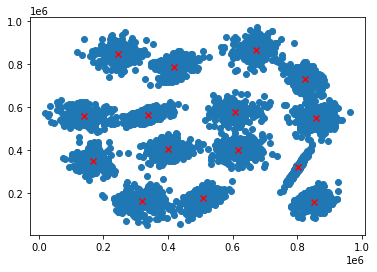

In [61]:
from pyspark.ml.clustering import KMeans
import pandas as pd
import matplotlib.pyplot as plt

#ler points.csv
points_df = spark.read.csv('file:///home/bigdata-vm/Desktop/BigDataAulasPUC/Datasets/points.csv', inferSchema=True,
                          sep='\t')

#visualizar dataset
points_pd = points_df.toPandas()
points_pd.head()

#plt.scatter(points_pd['_c0'], points_pd['_c1'])
#plt.show()

#rodar kmeans
points_vec = VectorAssembler(inputCols=['_c0', '_c1'], outputCol='features').transform(points_df)

kmeans = KMeans(k=15, seed=123, featuresCol='features')
model = kmeans.fit(points_vec)
preds_kmeans = model.transform(points_vec)

#visualizar
centers = model.clusterCenters()
centers_pd = pd.DataFrame(centers)

plt.scatter(points_pd['_c0'], points_pd['_c1'])
plt.scatter(centers_pd[0], centers_pd[1], color='red', marker='x')
plt.show()

## Pipelines

Até agora executamos cada passo separadamente, desde a preparação dos dados até a execução do algoritmo de ML. Spark oferece o recurso `Pipeline`, que permite unir todos os processos de transformação de características e o algoritmo em uma única execução. Você pode ver a documentação sobre pipelines [aqui](https://spark.apache.org/docs/latest/ml-pipeline.html). 

Pipelines são importantes pelo simples fato que auxiliam a evitar o problema de _vazamento de dados (data leakage)_, garantindo que todo o processo seja executado na partição de treinamento primeiro, e depois na partição de teste.

Vamos fazer o Pipeline para `flights_df`, encerrando com uma regressão linear.

In [65]:
from pyspark.ml import Pipeline

#divindo novamente a base
flights_train, flights_test = flights_df.randomSplit([0.8,0.2], seed=123)

#construindo o pipeline
indexer = StringIndexer(inputCols=['carrier', 'origin', 'dest'], 
                        outputCols=['carrier_idx', 'origin_idx', 'dest_idx'])
bucketizer = Bucketizer(splits=[0,3,6,9,12,15,18,21,24], inputCol='hour', outputCol='hour_bucket')
onehot = OneHotEncoder(inputCols=['carrier_idx', 'origin_idx', 'dest_idx', 'hour_bucket'],
                      outputCols=['carrier_oh', 'origin_oh', 'dest_oh', 'hour_oh'])
vec = VectorAssembler(inputCols=cols_to_use, outputCol='features')
lr = LinearRegression(labelCol='Y_num', featuresCol='features')
pipe_flights = Pipeline(stages=[indexer,bucketizer,onehot,vec,lr])

#checando os passos
print(pipe_flights.getStages())

#rodando o pipeline
preds_pipe = pipe_flights.fit(flights_train).transform(flights_test)
RMSE_pipe_flight = RegressionEvaluator().setLabelCol('Y_num').evaluate(preds_pipe)
print(RMSE_pipe_flight)

[StringIndexer_f5fd2d373e85, Bucketizer_bba5a7cd3e41, OneHotEncoder_1c14eabc2de5, VectorAssembler_f81eb1d800d3, LinearRegression_df63311b6714]


2021-12-18 15:30:58,177 WARN util.Instrumentation: [6e754042] regParam is zero, which might cause numerical instability and overfitting.


11.515351516328124


Vamos fazer o pipeline para `sms_df`, terminando em uma regressão logística.

In [66]:
sms_train, sms_test = sms_df.randomSplit([0.8,0.2], seed=123)

tokenizer = Tokenizer(inputCol='text', outputCol='tokens')
sw_remover = StopWordsRemover(inputCol='tokens', outputCol='tokens_clean')
hashingTF = HashingTF(inputCol='tokens_clean', outputCol='tf', numFeatures=1024)
idf = IDF(inputCol='tf', outputCol='features')
log_reg = LogisticRegression(labelCol='Y', featuresCol='features')

pipe_sms = Pipeline(stages=[tokenizer,sw_remover,hashingTF,idf,log_reg])

pred_pipe_sms = pipe_sms.fit(sms_train).transform(sms_test)
AUC_pipe = BinaryClassificationEvaluator().setLabelCol('Y').evaluate(pred_pipe_sms)
print(AUC_pipe)

0.9598947444308443


## Otimização e Validação Cruzada

Spark oferece também ferramentas de otimização e seleção de hiperparâmetros para ML, dentro do módulo `pyspark.ml.tuning` (veja a 
[documentação](https://spark.apache.org/docs/latest/ml-tuning.html)). Muitos algoritmos possuem vários hiperparâmetros que muitas das vezes só conseguem ser definidos empiricamente, rodando diversas configurações ou empregando técnicas de _busca em grade_. 

Para busca em grade, Spark oferece o objeto `ParamGridBuilder`. Esse recurso deve ser empregado em conjunto com um mecanismo de _Validação Cruzada_, executado com um `CrossValidator`. A Validação Cruzada é uma maneira muito eficiente de fazer otimização de parâmetros, pois é executada em diversas repartições dos dados de treinamento e oferece diversas visões de como um modelo se comporta. 

![Disponível em: https://drigols.medium.com/introdu%C3%A7%C3%A3o-a-valida%C3%A7%C3%A3o-cruzada-k-fold-2a6bced32a90](https://miro.medium.com/max/1202/0*O_491U1UfF1lIqz_.png)

Os módulos de otimização podem ser utilizados em conjunto com Pipeline. Vamos aproveitar os pipelines criados anteriormente e tentar otimizar os parâmetros dos algoritmos.

In [68]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

#criando um grid
param_grid_flights = ParamGridBuilder() \
                .addGrid(lr.regParam, [0.01,0.1,0.5,1]) \
                .addGrid(lr.elasticNetParam, [0, 0.5, 1]) \
                .addGrid(lr.maxIter, [100, 500, 1000]).build()

#criando um avaliador
evaluator = RegressionEvaluator().setLabelCol('Y_num')

#rodando validação cruzada
cv_flights = CrossValidator(estimator=pipe_flights,
                   estimatorParamMaps=param_grid_flights,
                   evaluator=evaluator,
                   numFolds=5)

cv_flights_model = cv_flights.fit(flights_train)


Vamos ver os parâmetros escolhidos para o melhor modelo.

In [69]:
cv_flights_model.bestModel.stages[4].extractParamMap()

{Param(parent='LinearRegression_df63311b6714', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2,
 Param(parent='LinearRegression_df63311b6714', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 1.0,
 Param(parent='LinearRegression_df63311b6714', name='epsilon', doc='The shape parameter to control the amount of robustness. Must be > 1.0. Only valid when loss is huber'): 1.35,
 Param(parent='LinearRegression_df63311b6714', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='LinearRegression_df63311b6714', name='fitIntercept', doc='whether to fit an intercept term.'): True,
 Param(parent='LinearRegression_df63311b6714', name='labelCol', doc='label column name.'): 'Y_num',
 Param(parent='LinearRegression_df63311b6714', name='loss', doc='The loss function to be optimized. Supported options: squaredError, huber.'): 'squaredError

E finalmente, avaliar:

In [70]:
preds_best_flight = cv_flights_model.transform(flights_test)
RMSE_best_flights = evaluator.evaluate(preds_best_flight)
print(RMSE_best_flights)

11.499625518156355


Para finalizar, vamos executar um cross validation no nosso `sms_df`. Aproveite o pipeline construído. Uma vantagem do `ParamGridBuilder` é que ele não se limita a ajustar parâmetros do algoritmo de ML. Tente ajustar o parâmetro de `HashingTF` também, além dos parâmetros selecionados para regressão logística.

In [71]:
param_grid_sms = ParamGridBuilder() \
                    .addGrid(hashingTF.numFeatures, [1024,2048,4196,8392]) \
                    .addGrid(log_reg.regParam, [0.001, 0.01, 0.1, 1]) \
                    .addGrid(log_reg.elasticNetParam, [0,1]).build()

auc_eval = BinaryClassificationEvaluator().setLabelCol('Y')

cv_sms = CrossValidator(estimator=pipe_sms,
                       estimatorParamMaps=param_grid_sms,
                       evaluator=auc_eval,
                       numFolds=5)

cv_sms_model = cv_sms.fit(sms_train)

In [72]:
cv_sms_model.bestModel.stages[2].extractParamMap()

{Param(parent='HashingTF_5dd20b118cce', name='binary', doc='If True, all non zero counts are set to 1. This is useful for discrete probabilistic models that model binary events rather than integer counts. Default False.'): False,
 Param(parent='HashingTF_5dd20b118cce', name='numFeatures', doc='Number of features. Should be greater than 0.'): 8392,
 Param(parent='HashingTF_5dd20b118cce', name='outputCol', doc='output column name.'): 'tf',
 Param(parent='HashingTF_5dd20b118cce', name='inputCol', doc='input column name.'): 'tokens_clean'}

In [73]:
cv_sms_model.bestModel.stages[4].extractParamMap()

{Param(parent='LogisticRegression_ea6aac040c5f', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2,
 Param(parent='LogisticRegression_ea6aac040c5f', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0,
 Param(parent='LogisticRegression_ea6aac040c5f', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'): 'auto',
 Param(parent='LogisticRegression_ea6aac040c5f', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='LogisticRegression_ea6aac040c5f', name='fitIntercept', doc='whether to fit an intercept term.'): True,
 Param(parent='LogisticRegression_ea6aac040c5f', name='labelCol', doc='label column name.'): 'Y',
 Param(parent='LogisticRegression_ea6aac040c5f', name='maxBlockSizeInMB', doc='maximum memory in MB for stack

In [74]:
print(auc_eval.evaluate(cv_sms_model.transform(sms_test)))

0.9918390887463134
